In [1]:
import os
import sys

import torch.nn as nn
import torch.optim as optim
import torchvision
from sklearn.decomposition import PCA
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.datasets import MNIST

# tell jupyter where are local modules are
module_path = os.path.abspath('.')
if module_path not in sys.path:
    sys.path.append(module_path)

from dae import DAE, Naive_DAE
from demo_train_utils import train_rbm
from rbm import RBM
from utils import *

# Setup

In [2]:
print(f"Using device {DEVICE}")
seed_everything(42)

MNIST_DIR = "/home/ubuntu/efs/mnist/" # directory to store MNIST data. Set it here.
MNIST_NUM_PIXELS = 784 # 28x28

Using device cuda


# Load Data

In [3]:
train = MNIST(MNIST_DIR, train=True, download=False, transform=torchvision.transforms.ToTensor())
test = MNIST(MNIST_DIR, train=False, download=False, transform=torchvision.transforms.ToTensor())
train_dl = DataLoader(train, batch_size=1, shuffle=False)
test_dl = DataLoader(test, batch_size=1, shuffle=False)

Flatten images to a 784-dimensional vector (28x28)

In [4]:
def flatten_input(dl):
    flat_input = []
    labels = []
    for features, targets in train_dl:
        features = Variable(features.view(-1, MNIST_NUM_PIXELS))
        flat_input.append(features.detach().cpu().numpy())
        labels.append(targets.detach().cpu().numpy())
    return np.concatenate(flat_input), np.concatenate(labels)
flat_train_input, train_labels = flatten_input(train_dl)
flat_test_input, test_labels = flatten_input(test_dl)
train_dl_flat = DataLoader(TensorDataset(torch.Tensor(flat_train_input).to(DEVICE), torch.Tensor(flat_train_input).to(DEVICE)), batch_size=64, shuffle=False)

# Naive Deep Autoencoder

This autoencoder does a very poor job and gets stuck at a generic implementation!

In [ ]:
# fine-tune autoencoder
lr = 1e-3
dae = Naive_DAE([784,1000,500,250,2]).to(DEVICE)
loss = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr)
num_epochs = 10

# train
running_loss = float("inf")
for epoch in range(num_epochs):
    losses = []
    for i, (data, target) in enumerate(train_dl_flat): 
        v_pred = dae(data)
        batch_loss = loss(data, v_pred) # difference between actual and reconstructed   
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
        # show visual progress every 10 epochs
        display_output(data, v_pred)

# Train RBMs
Let's pretrain some RBMs first. The layers we will train are: 784-1000-500-250-2 

In [5]:
hidden_dimensions = [
    {
        "hidden_dim": 1000, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 28, 
        "display_dim2": 28, 
        "use_gaussian": False
    }, 
    {
        "hidden_dim": 500, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 40, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 250, 
        "num_epochs": 10, 
        "learning_rate": 0.1, 
        "display_dim1": 25, 
        "display_dim2": 20, 
        "use_gaussian": False
    },
    {
        "hidden_dim": 2, 
        "num_epochs": 30, 
        "learning_rate": 0.001, # use much lower LR for gaussian to avoid exploding gradient
        "display_dim1": 25, 
        "display_dim2": 10, 
        "use_gaussian": True # use a Gaussian distribution for the last hidden layer to let it take advantage of continuous values
    }
]

Train RBMs

784 to 1000
epoch 0: 0.015547390095889568
epoch 1: 0.010525600053369999
epoch 2: 0.009791692718863487
epoch 3: 0.009431914426386356
epoch 4: 0.009224973618984222
epoch 5: 0.010288812220096588
epoch 6: 0.00950600579380989
epoch 7: 0.00916724931448698
epoch 8: 0.008947363123297691
epoch 9: 0.008794423192739487
Original (top) and Reconstructed (bottom)


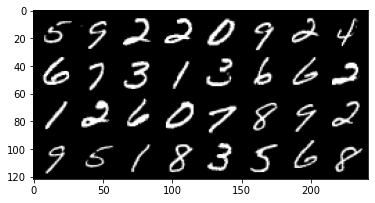

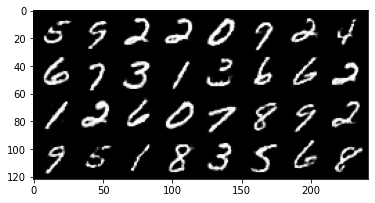

1000 to 500
epoch 0: 0.016659237444400787
epoch 1: 0.010340237058699131
epoch 2: 0.00919298268854618
epoch 3: 0.008486040867865086
epoch 4: 0.007965213619172573
epoch 5: 0.007687955163419247
epoch 6: 0.0065120914950966835
epoch 7: 0.006029023323208094
epoch 8: 0.005811628885567188
epoch 9: 0.005690611898899078
Original (top) and Reconstructed (bottom)


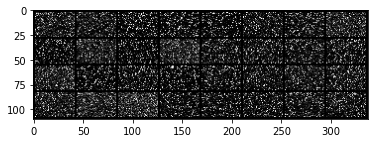

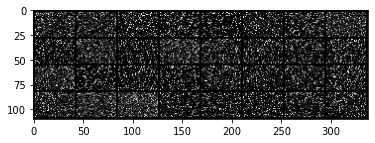

500 to 250
epoch 0: 0.02185017615556717
epoch 1: 0.013505782000720501
epoch 2: 0.012305144220590591
epoch 3: 0.011711355298757553
epoch 4: 0.011343013495206833
epoch 5: 0.011999411508440971
epoch 6: 0.01126585528254509
epoch 7: 0.010815281420946121
epoch 8: 0.010565184988081455
epoch 9: 0.010322474874556065
Original (top) and Reconstructed (bottom)


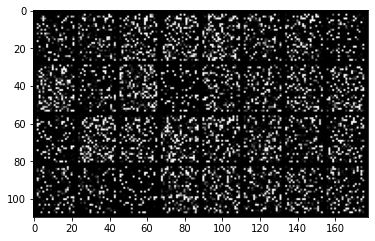

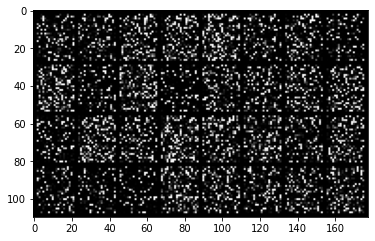

250 to 2
epoch 0: 0.16455085575580597
epoch 1: 0.14200958609580994
epoch 2: 0.13630329072475433
epoch 3: 0.13335850834846497
epoch 4: 0.13149233162403107
epoch 5: 0.1291409283876419
epoch 6: 0.1281840056180954
epoch 7: 0.12805068492889404
epoch 8: 0.1280086785554886
epoch 9: 0.1280180811882019
epoch 10: 0.1279916912317276
epoch 11: 0.12800738215446472
epoch 12: 0.1279977262020111
epoch 13: 0.12800706923007965
epoch 14: 0.1280042678117752
epoch 15: 0.12800252437591553
epoch 16: 0.1280079334974289
epoch 17: 0.12799419462680817
epoch 18: 0.12800361216068268
epoch 19: 0.1280118077993393
epoch 20: 0.1279991865158081
epoch 21: 0.12800626456737518
epoch 22: 0.12799417972564697
epoch 23: 0.12800268828868866
epoch 24: 0.1279994696378708
epoch 25: 0.12800714373588562
epoch 26: 0.12799063324928284
epoch 27: 0.12800680100917816
epoch 28: 0.12800808250904083
epoch 29: 0.12799759209156036
Original (top) and Reconstructed (bottom)


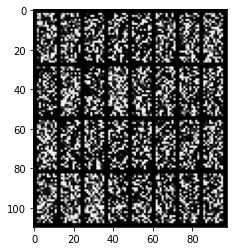

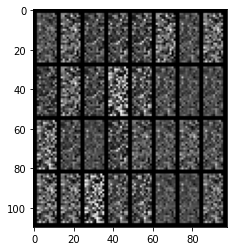

In [6]:
# get initial iteration of new training dl
new_train_dl = train_dl_flat

visible_dim = MNIST_NUM_PIXELS
hidden_dim = None
models = [] # trained RBM models
for configs in hidden_dimensions:
    
    # parse configs
    hidden_dim = configs["hidden_dim"]
    num_epochs = configs["num_epochs"]
    lr = configs["learning_rate"]
    d1 = configs["display_dim1"]
    d2 = configs["display_dim2"]
    use_gaussian = configs["use_gaussian"]
    
    # train RBM
    print(f"{visible_dim} to {hidden_dim}")
    model, v, v_pred = train_rbm(new_train_dl, visible_dim, hidden_dim, k=1, num_epochs=num_epochs, lr=lr, use_gaussian=use_gaussian)
    models.append(model)
    
    # display sample output
    display_output(v, v_pred, d1, d2)

    # rederive new data loader based on hidden activations of trained model
    new_data = []
    for features, targets in new_train_dl:
        p, sample = model.sample_h(features)
        new_data.append(p.detach().cpu().numpy())
    new_input = np.concatenate(new_data)
    new_train_dl = DataLoader(TensorDataset(torch.Tensor(new_input).to(DEVICE), torch.Tensor(new_input).to(DEVICE)), batch_size=64, shuffle=False)
    
    # update new visible_dim for next RBM
    visible_dim = hidden_dim

# Fine-tune Deep Autoencoder from built from RBMs

/home/ubuntu/miniconda3/envs/kaggle/lib/python3.8/site-packages/torch/nn/modules/container.py:434: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Epoch 0: 0.04662885931111983
Epoch 1: 0.04049604653970583
Epoch 2: 0.0384954277521321
Epoch 3: 0.03732464934931572
Epoch 4: 0.03650266187253601
Epoch 5: 0.035873050843156985
Epoch 6: 0.035350663986589224
Epoch 7: 0.03488856992090562
Epoch 8: 0.03450724001187506
Epoch 9: 0.03424265541668449
Original (top) and Reconstructed (bottom)


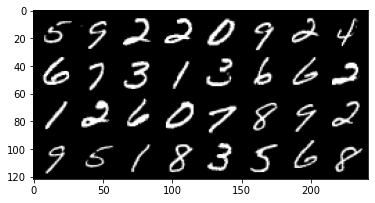

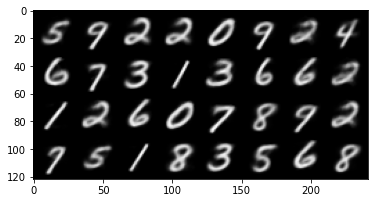

Epoch 10: 0.03400609588254489
Epoch 11: 0.03374339814490474
Epoch 12: 0.033500076247764424
Epoch 13: 0.033395966798909056
Epoch 14: 0.03314510064084392
Epoch 15: 0.03305619911376093
Epoch 16: 0.03286721097873345
Epoch 17: 0.03271355106235186
Epoch 18: 0.032603454825752325
Epoch 19: 0.032357035643621676
Original (top) and Reconstructed (bottom)


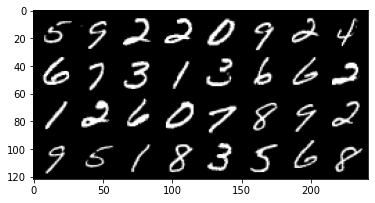

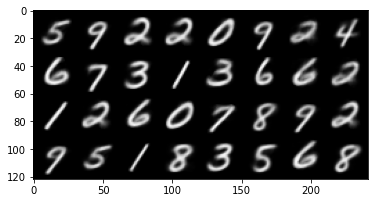

Epoch 20: 0.03220279304894494
Epoch 21: 0.03217605856467666
Epoch 22: 0.032042407996650694
Epoch 23: 0.031900416307056
Epoch 24: 0.03176616628302821
Epoch 25: 0.031679489574373276
Epoch 26: 0.0315886470379987
Epoch 27: 0.031506955190730504
Epoch 28: 0.031342352045449745
Epoch 29: 0.03129634669801192
Original (top) and Reconstructed (bottom)


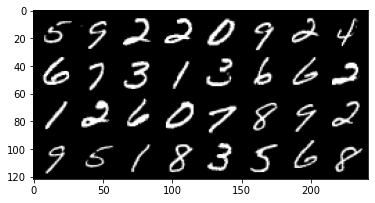

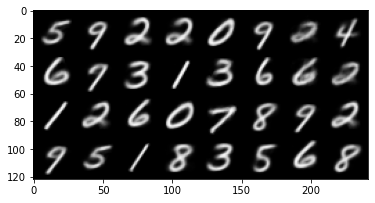

Epoch 30: 0.03114307329241337
Epoch 31: 0.031191790067374325
Epoch 32: 0.031087080320553868
Epoch 33: 0.031083389229055788
Epoch 34: 0.03102661685736131
Epoch 35: 0.030978235279096725
Epoch 36: 0.030799436720528962
Epoch 37: 0.03072708235509487
Epoch 38: 0.030761634045318245
Epoch 39: 0.030567258924071087
Original (top) and Reconstructed (bottom)


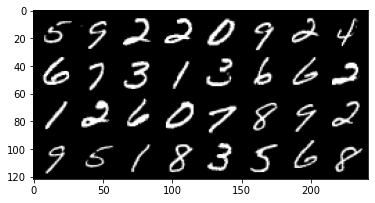

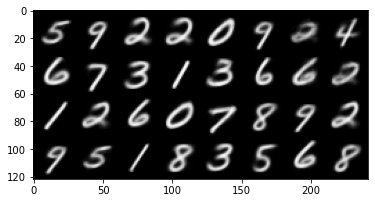

Epoch 40: 0.03072651792992788
Epoch 41: 0.03061939573991718
Epoch 42: 0.03075788645093629
Epoch 43: 0.030584115310629673
Epoch 44: 0.030711780256554008
Epoch 45: 0.030420300713591357
Epoch 46: 0.03034965524962271
Epoch 47: 0.030250380526600618
Epoch 48: 0.030213288664976672
Epoch 49: 0.03016929048647695
Original (top) and Reconstructed (bottom)


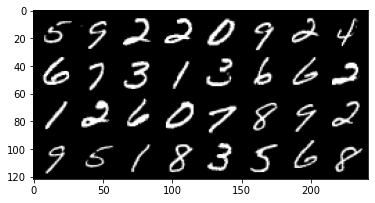

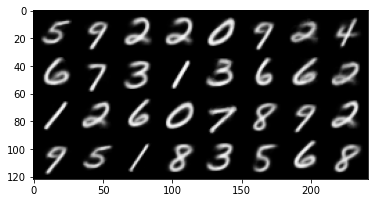

In [7]:
# fine-tune autoencoder
lr = 1e-3
dae = DAE(models).to(DEVICE)
loss = nn.MSELoss()
optimizer = optim.Adam(dae.parameters(), lr)
num_epochs = 50

# train
running_loss = float("inf")
for epoch in range(num_epochs):
    losses = []
    for i, (data, target) in enumerate(train_dl_flat): 
        v_pred = dae(data)
        batch_loss = loss(data, v_pred) # difference between actual and reconstructed   
        losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    running_loss = np.mean(losses)
    print(f"Epoch {epoch}: {running_loss}")
    if epoch % 10 == 9:
        # show visual progress every 10 epochs
        display_output(data, v_pred)

# Plot Learned 2d Representations

Here we plot the learned 2d representations on test data. For comparison, we also show the results from PCA

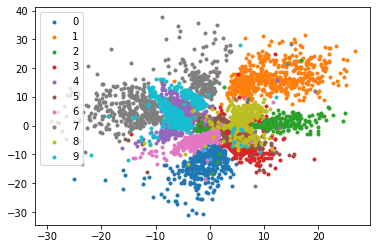

In [8]:
transformed = dae.encode(torch.Tensor(flat_test_input[0:5000]).to(DEVICE)).detach().cpu().numpy()
display_2d_repr(transformed, test_labels, "dae_repr.png")

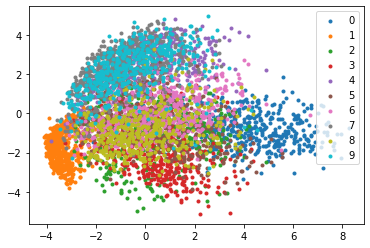

In [9]:
pca = PCA(n_components=2, random_state=10)
pca.fit(flat_train_input)
transformed = pca.transform(flat_test_input[0:5000])
display_2d_repr(transformed, test_labels, "pca_repr.png")